<a href="https://colab.research.google.com/github/ChyavanShenoy/AAI-500-Final-Project/blob/main/Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [292]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import joblib
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [293]:
df = pd.read_csv('station_day.csv')
df.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [294]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,86410.000000,65329.000000,90929.000000,91488.000000,92535.000000,59930.000000,95037.000000,82831.000000,82467.000000,76580.000000,69333.000000,22898.000000,87025.000000
mean,80.272571,157.968427,23.123424,35.240760,41.195055,28.732875,1.605749,12.257634,38.134836,3.358029,15.345394,2.423446,179.749290
std,76.526403,123.418672,34.491019,29.510827,45.145976,24.897797,4.369578,12.984723,39.128004,11.156234,29.348587,6.472409,131.324339
min,0.020000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,8.000000
25%,31.880000,70.150000,4.840000,15.090000,13.970000,11.900000,0.530000,5.040000,18.895000,0.160000,0.690000,0.000000,86.000000
50%,55.950000,122.090000,10.290000,27.210000,26.660000,23.590000,0.910000,8.950000,30.840000,1.210000,4.330000,0.400000,132.000000
75%,99.920000,208.670000,24.980000,46.930000,50.500000,38.137500,1.450000,14.920000,47.140000,3.610000,17.510000,2.110000,254.000000
max,1000.000000,1000.000000,470.000000,448.050000,467.630000,418.900000,175.810000,195.650000,963.000000,455.030000,454.850000,170.370000,2049.000000


In [295]:
learning_vars = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
# learning_vars = ['PM2.5 AQI Value', 'NO2 AQI Value', 'Ozone AQI Value', 'CO AQI Value']
target_classification = 'AQI_Bucket'
# target_classification = 'AQI Category'
target_regression = 'AQI'
# target_regression = 'AQI Value'
fix_columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI']
# fix_columns = ['PM2.5 AQI Value', 'NO2 AQI Value', 'Ozone AQI Value', 'CO AQI Value', 'AQI Value']

In [296]:
# df['AQI'] = np.log1p(df['AQI'])

In [297]:
# for var in learning_vars:
#     df[var] = winsorize(df[var], limits=[0, 0.25])  # Cap top 5% of values

In [298]:
# Q1 = df[learning_vars].quantile(0.25)
# Q3 = df[learning_vars].quantile(0.75)
# IQR = Q3 - Q1
# df = df[~((df[learning_vars] < (Q1 - 1.5 * IQR)) | (df[learning_vars] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [299]:
# imputer = SimpleImputer(strategy='median')
# df[fix_columns] = imputer.fit_transform(df[fix_columns])

knn_imputer = KNNImputer(n_neighbors=5) 
df[fix_columns] = knn_imputer.fit_transform(df[fix_columns])

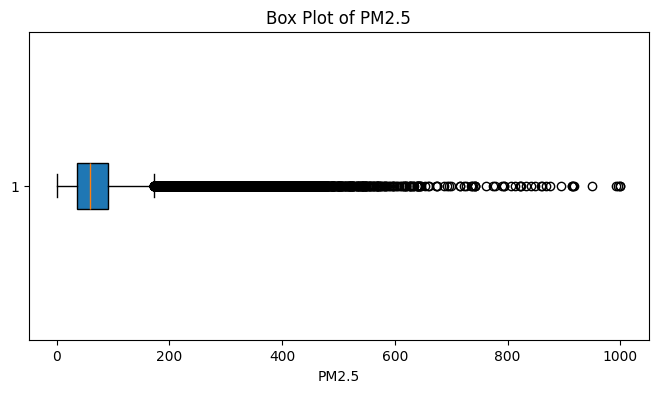

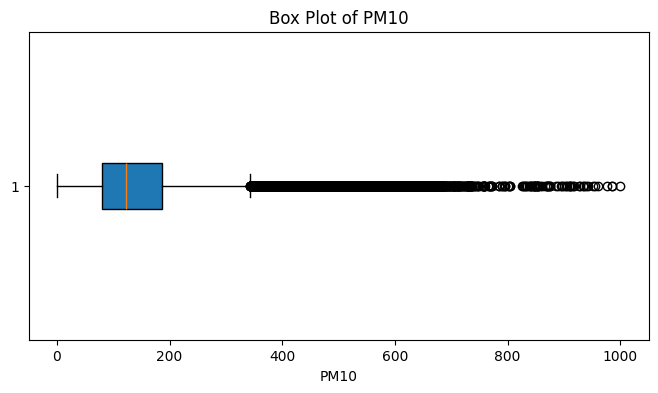

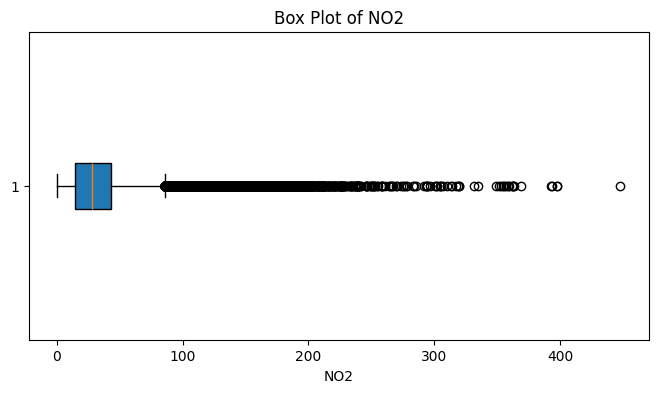

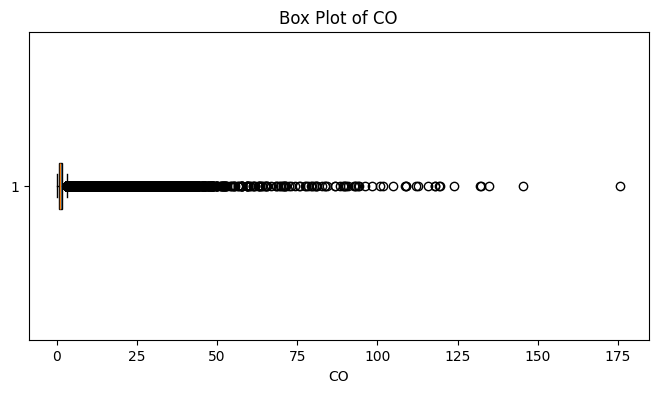

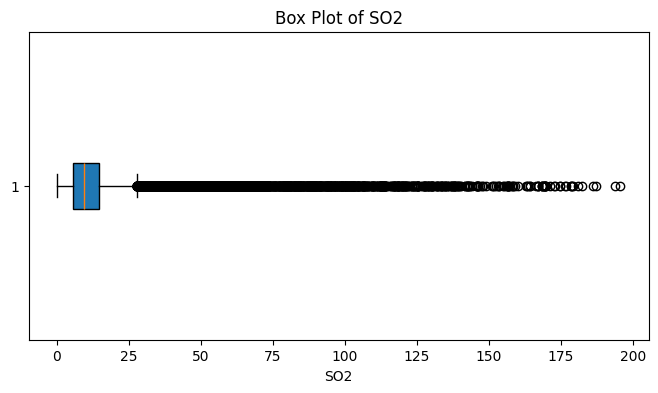

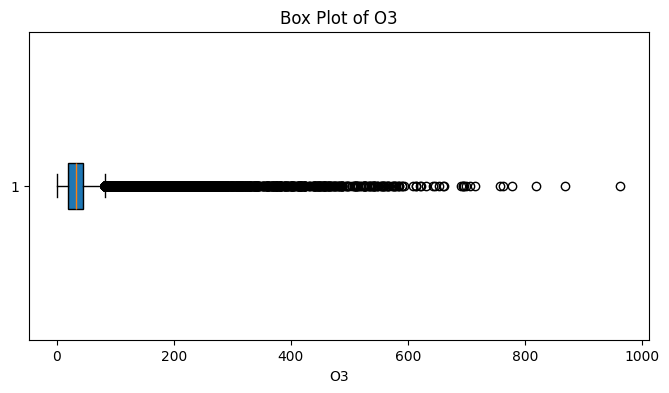

In [300]:
for var in learning_vars:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[var], vert=False, patch_artist=True, showfliers=True)
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.show()

In [301]:
df.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,84.6,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [302]:
label_encoder = LabelEncoder()
df[target_classification] = label_encoder.fit_transform(df[target_classification])

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       108035 non-null  float64
 3   PM10        108035 non-null  float64
 4   NO          90929 non-null   float64
 5   NO2         108035 non-null  float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          108035 non-null  float64
 9   SO2         108035 non-null  float64
 10  O3          108035 non-null  float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         108035 non-null  float64
 15  AQI_Bucket  108035 non-null  int64  
dtypes: float64(13), int64(1), object(2)
memory usage: 13.2+ MB


In [304]:
df.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,84.6,6
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,1
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,1
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,1
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,1


In [305]:
X = df[learning_vars]

y_class = df[target_classification]
y_reg = df[target_regression]

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=0)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=0)

In [306]:
smote = SMOTE(random_state=0)
X_train_class, y_train_class = smote.fit_resample(X_train_class, y_train_class)

In [307]:
X.head()

,PM2.5,PM10,NO2,CO,SO2,O3
0,71.36,115.75,20.65,0.10,10.76,109.26
1,81.40,124.50,20.50,0.12,15.24,127.09
2,78.32,129.06,26.00,0.14,26.96,117.44
3,88.76,135.32,30.85,0.11,33.59,111.81
4,64.18,104.09,28.07,0.09,19.00,138.18


In [308]:
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

In [309]:
logistic_model = LogisticRegression(max_iter=2000)
logistic_model.fit(X_train_class, y_train_class)
y_pred_class_logistic = logistic_model.predict(X_test_class)
print("Logistic Regression Classification Report:")
print(classification_report(y_test_class, y_pred_class_logistic, zero_division=1))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.80      0.52      1125
           1       0.71      0.57      0.63      5895
           2       0.47      0.53      0.50      2282
           3       0.64      0.58      0.61      4749
           4       0.63      0.77      0.70       999
           5       0.67      0.65      0.66      2318
           6       0.70      0.69      0.70      4239

    accuracy                           0.62     21607
   macro avg       0.60      0.66      0.62     21607
weighted avg       0.64      0.62      0.63     21607



In [310]:
dtree_classifier = DecisionTreeClassifier(random_state=0,max_depth=7,min_samples_split=70)
dtree_classifier.fit(X_train_class, y_train_class)
y_pred_class_dtree=dtree_classifier.predict(X_test_class)
print("Decision Tree Classification Report:")
print(classification_report(y_test_class, y_pred_class_dtree, zero_division=1))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.81      0.62      1125
           1       0.71      0.69      0.70      5895
           2       0.52      0.69      0.59      2282
           3       0.71      0.67      0.69      4749
           4       0.67      0.85      0.75       999
           5       0.71      0.75      0.73      2318
           6       0.97      0.65      0.78      4239

    accuracy                           0.70     21607
   macro avg       0.69      0.73      0.70     21607
weighted avg       0.73      0.70      0.70     21607



In [311]:
dtree_regressor = DecisionTreeRegressor(random_state=0,max_depth=10,min_samples_leaf=3,min_samples_split=90)
dtree_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_dt=dtree_regressor.predict(X_test_reg)
print("Decision Tree Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_dt))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_dt))

Decision Tree Regression Metrics:
MSE: 2363.738906002378
R2 Score: 0.8331661176664715


In [312]:
rf_classifier = RandomForestClassifier(n_estimators=1, random_state=0)
rf_classifier.fit(X_train_class, y_train_class)
y_pred_class_rf = rf_classifier.predict(X_test_class)
print("Random Forest Classification Report:")
print(classification_report(y_test_class, y_pred_class_rf, zero_division=1))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58      1125
           1       0.68      0.59      0.63      5895
           2       0.46      0.55      0.50      2282
           3       0.67      0.63      0.65      4749
           4       0.63      0.75      0.69       999
           5       0.64      0.65      0.64      2318
           6       0.74      0.73      0.73      4239

    accuracy                           0.64     21607
   macro avg       0.62      0.66      0.63     21607
weighted avg       0.65      0.64      0.64     21607



In [313]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_rf = rf_regressor.predict(X_test_reg)
print("Random Forest Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_rf))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_rf))

Random Forest Regression Metrics:
MSE: 2016.212922054424
R2 Score: 0.8576946766230411


In [314]:
xgb_classifier = xgb.XGBClassifier(random_state=0,max_depth=10,learning_rate=0.1,n_estimators= 100)
xgb_classifier.fit(X_train_class, y_train_class)
y_pred_class_xgb=xgb_classifier.predict(X_test_class)
print("XGBoost Classification Report:")
print(classification_report(y_test_class, y_pred_class_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.70      1125
           1       0.77      0.70      0.73      5895
           2       0.55      0.73      0.63      2282
           3       0.73      0.77      0.75      4749
           4       0.74      0.83      0.78       999
           5       0.72      0.77      0.74      2318
           6       0.97      0.70      0.81      4239

    accuracy                           0.74     21607
   macro avg       0.73      0.76      0.73     21607
weighted avg       0.76      0.74      0.74     21607



In [315]:
xgb_regressor = xgb.XGBRegressor(random_state=0,max_depth=5,n_estimators= 100)
xgb_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_xgb=xgb_regressor.predict(X_test_reg)
print("XGBoost Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_xgb))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_xgb))

XGBoost Regression Metrics:
MSE: 2098.5933410916814
R2 Score: 0.851880225161694


In [316]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train_class, y_train_class)
y_pred_class_mlp = mlp_classifier.predict(X_test_class)
print("MLP Classification Report:")
print(classification_report(y_test_class, y_pred_class_mlp, zero_division=1))

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.89      0.62      1125
           1       0.74      0.71      0.73      5895
           2       0.54      0.71      0.61      2282
           3       0.74      0.66      0.70      4749
           4       0.72      0.83      0.77       999
           5       0.70      0.77      0.73      2318
           6       0.97      0.68      0.80      4239

    accuracy                           0.71     21607
   macro avg       0.70      0.75      0.71     21607
weighted avg       0.75      0.71      0.72     21607



In [317]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_mlp = mlp_regressor.predict(X_test_reg)
print("MLP Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_mlp))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_mlp))

MLP Regression Metrics:
MSE: 2141.0665683497164
R2 Score: 0.8488824433928623


In [318]:
y_dual = df[[target_classification, target_regression]]
X_train_dual, X_test_dual, y_train_dual, y_test_dual = train_test_split(X, y_dual, test_size=0.2, random_state=42)

X_train_dual = scaler.fit_transform(X_train_dual)
X_test_dual = scaler.transform(X_test_dual)

mlp_dual = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_dual.fit(X_train_dual, y_train_dual)
y_pred_dual = mlp_dual.predict(X_test_dual)

print("MLP Dual Prediction Metrics:")
print("MSE (AQI_Bucket):", mean_squared_error(y_test_dual[target_classification], y_pred_dual[:, 0]))
print("MSE (AQI):", mean_squared_error(y_test_dual[target_regression], y_pred_dual[:, 1]))

MLP Dual Prediction Metrics:
MSE (AQI_Bucket): 1.9518209883546958
MSE (AQI): 2036.0267869457055


In [319]:
joblib.dump(logistic_model, 'logistic_model.pkl')
joblib.dump(dtree_classifier,'dtree_classifier.pkl')
joblib.dump(dtree_regressor,'dtree_regressor.pkl')
joblib.dump(rf_classifier, 'rf_classifier.pkl')
joblib.dump(rf_regressor, 'rf_regressor.pkl')
joblib.dump(xgb_classifier,'xgb_classifier.pkl')
joblib.dump(xgb_regressor,'xgb_regressor.pkl')
joblib.dump(mlp_classifier, 'mlp_classifier.pkl')
joblib.dump(mlp_regressor, 'mlp_regressor.pkl')
joblib.dump(mlp_dual, 'mlp_dual.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [320]:
def predict_models(x_new_test):
    # Load models and scaler
    logistic_model = joblib.load('logistic_model.pkl')
    dtree_classifier = joblib.load('dtree_classifier.pkl')
    dtree_regressor = joblib.load('dtree_regressor.pkl')
    rf_classifier = joblib.load('rf_classifier.pkl')
    rf_regressor = joblib.load('rf_regressor.pkl')
    xgb_classifier = joblib.load('xgb_classifier.pkl')
    xgb_regressor = joblib.load('xgb_regressor.pkl')
    mlp_classifier = joblib.load('mlp_classifier.pkl')
    mlp_regressor = joblib.load('mlp_regressor.pkl')
    mlp_dual = joblib.load('mlp_dual.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')

    # Scale the custom data
    x_new_test_scaled = scaler.transform(x_new_test)

    # Make predictions
    logistic_pred = logistic_model.predict(x_new_test_scaled)
    logistic_label = label_encoder.inverse_transform(logistic_pred)

    dtree_class_pred = dtree_classifier.predict(x_new_test_scaled)
    dtree_class_label = label_encoder.inverse_transform(dtree_class_pred)

    dtree_reg_pred = dtree_regressor.predict(x_new_test_scaled)

    rf_class_pred = rf_classifier.predict(x_new_test_scaled)
    rf_class_label = label_encoder.inverse_transform(rf_class_pred)

    rf_reg_pred = rf_regressor.predict(x_new_test_scaled)

    xgb_class_pred = xgb_classifier.predict(x_new_test_scaled)
    xgb_class_label = label_encoder.inverse_transform(xgb_class_pred)

    xgb_reg_pred = xgb_regressor.predict(x_new_test_scaled)

    mlp_class_pred = mlp_classifier.predict(x_new_test_scaled)
    mlp_class_label = label_encoder.inverse_transform(mlp_class_pred)

    mlp_reg_pred = mlp_regressor.predict(x_new_test_scaled)

    mlp_dual_pred = mlp_dual.predict(x_new_test_scaled)
    mlp_dual_class_label = label_encoder.inverse_transform(mlp_dual_pred[:, 0].astype(int))
    mlp_dual_reg_pred = mlp_dual_pred[:, 1]

    # Print predictions
    print("Logistic Regression Prediction:", logistic_label)
    print("Decison Tree Classification Prediction:", dtree_class_label)
    print("Decision Tree Regression Prediction:", dtree_reg_pred)
    print("Random Forest Classification Prediction:", rf_class_label)
    print("Random Forest Regression Prediction:", rf_reg_pred)
    print("XGBoost Classification Prediction:", xgb_class_label)
    print("XGBoost Regression Prediction:", xgb_reg_pred)
    print("MLP Classification Prediction:", mlp_class_label)
    print("MLP Regression Prediction:", mlp_reg_pred)
    print("MLP Dual Prediction - Classification Label:", mlp_dual_class_label)
    print("MLP Dual Prediction - Regression Value:", mlp_dual_reg_pred)


In [323]:
custom_test_data = {
    'PM2.5': [21],
    'PM10': [19],
    'NO2': [8],
    'CO': [1],
    'SO2': [1],
    'O3': [10]
    # 'PM2.5 AQI Value': [21],
    # 'NO2 AQI Value': [8],
    # 'Ozone AQI Value': [10],
    # 'CO AQI Value': [1]
}
x_new_test = pd.DataFrame(custom_test_data)

In [324]:
predict_models(x_new_test)

Logistic Regression Prediction: ['Good']
Decison Tree Classification Prediction: ['Satisfactory']
Decision Tree Regression Prediction: [52.13196217]
Random Forest Classification Prediction: [nan]
Random Forest Regression Prediction: [64.562]
XGBoost Classification Prediction: ['Satisfactory']
XGBoost Regression Prediction: [62.466713]
MLP Classification Prediction: ['Satisfactory']
MLP Regression Prediction: [61.90952046]
MLP Dual Prediction - Classification Label: ['Poor']
MLP Dual Prediction - Regression Value: [60.53428766]
